# Manual Question Applicability Evaluation

This notebook allows for manual evaluation of whether questions are applicable to images across different datasets (waymo, nuimages, bdd).

In [22]:
import argparse
import io
import json
import os
import pickle
import random
import sqlite3
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, clear_output
from torchvision import transforms
from tqdm.notebook import tqdm
from graid.utilities.common import project_root_dir

In [23]:
# Set the same random seed as in eval_vlms.py
random.seed(42)

# Define paths to datasets
DB_PATH = project_root_dir() / "data/databases_ablations"

bdd_path = project_root_dir() / "data/bdd_val_filtered"
nu_path = project_root_dir() / "data/nuimages_val_filtered"
waymo_path = project_root_dir() / "data/waymo_validation_interesting"

In [ ]:
def load_dataset(dataset_name, sample_size=50):
    """Load dataset and return sampled dataframes"""
    
    if dataset_name.lower() == "bdd":
        db_base_path = bdd_path
        db_path = str(DB_PATH / "bdd_val_0.2_/co_dino_5scale_swin_l_lsj_16xb1_3x_coco.py.sqlite")
    elif dataset_name.lower() == "nuimages":
        db_base_path = nu_path
        db_path = str(DB_PATH / "nuimage_val_0.2_/co_dino_5scale_swin_l_lsj_16xb1_3x_coco.py.sqlite")
    elif dataset_name.lower() == "waymo":
        db_base_path = waymo_path
        db_path = str(DB_PATH / "waymo_val_0.2_/co_dino_5scale_swin_l_lsj_16xb1_3x_coco.py.sqlite")
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}. Choose from: bdd, nuimages, waymo")
    
    print(f"Loading dataset from {db_path}")
    
    # Connect to SQLite database
    conn = sqlite3.connect(db_path)
    
    # Get list of all tables
    tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql(tables_query, conn)["name"].tolist()
    
    # Load dataframes
    dataframes = {}
    for table in tables:
        df = pd.read_sql(f"SELECT * FROM '{table}'", conn)
        dataframes[table] = df
    
    conn.close()
    
    # Filter and sample dataframes
    sampled_dataframes = {}
    print("Filtering rows...")
    
    # Optimize image processing: Process all tables for each image
    # This follows the optimization from the memory about reversing loop order
    # to optimize image caching
    
    # First, collect all image paths and their associated questions across all tables
    all_image_data = {}
    
    for table_name, df in dataframes.items():
        for img_idx in tqdm(range(len(df))):
            row = df.iloc[img_idx]
            d = row.to_dict()
            
            pkl_path, v = d["key"], json.loads(d["value"])
            qa_list = v.get("qa_list", None)
            
            if not qa_list or qa_list == "Question not applicable":
                continue
                
            if isinstance(qa_list[0], list):
                qa_list = [random.choice(qa_list)]
                
            # Add this row to our collection, indexed by table
            if pkl_path not in all_image_data:
                all_image_data[pkl_path] = {}
            
            if table_name not in all_image_data[pkl_path]:
                all_image_data[pkl_path][table_name] = []
            
            all_image_data[pkl_path][table_name].append(row)
    
    # Now build our filtered dataframes from the collected data
    for table_name in dataframes.keys():
        filtered_rows = []
        
        for pkl_path, tables_data in all_image_data.items():
            if table_name in tables_data:
                filtered_rows.extend(tables_data[table_name])
        
        filtered_df = pd.DataFrame(filtered_rows).reset_index(drop=True)
        
        # Keep track of available sample size
        available_samples = len(filtered_df)
        
        if available_samples >= sample_size:
            sampled_df = filtered_df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        else:
            print(f"Table '{table_name}' has only {available_samples} valid rows. Using all.")
            sampled_df = filtered_df.copy()
            
        sampled_dataframes[table_name] = (sampled_df, available_samples)

    # Determine the minimum available sample size across all tables
    # This ensures we use the same number of samples for each table to avoid bias
    min_available_samples = sample_size  # Start with the requested sample size
    
    for table_name, (_, available_samples) in sampled_dataframes.items():
        min_available_samples = min(min_available_samples, available_samples)
    
    # Ensure we have at least 1 sample
    min_available_samples = max(1, min_available_samples)
    print(f"\nUsing a consistent sample size of {min_available_samples} across all tables for fair comparison\n")
    
    # Update sampled dataframes to use consistent sample size
    for table_name, (sampled_df, _) in sampled_dataframes.items():
        if len(sampled_df) > min_available_samples:
            # Resample to the consistent size
            sampled_df = sampled_df.iloc[:min_available_samples].reset_index(drop=True)
            sampled_dataframes[table_name] = (sampled_df, min_available_samples)
    
    return sampled_dataframes, db_base_path

In [25]:
def load_checkpoint(dataset_name, checkpoint_path=None):
    """Load checkpoint if exists, otherwise return empty data"""
    if checkpoint_path is None:
        checkpoint_path = f"manual_eval_{dataset_name}_checkpoint.json"
    
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, 'r') as f:
                checkpoint = json.load(f)
                print(f"Loaded checkpoint: Current table: {checkpoint.get('current_table', '')}, "
                      f"Index: {checkpoint.get('current_idx', 0)}, "
                      f"Global yes count: {checkpoint.get('yes_count', 0)}, "
                      f"Global no count: {checkpoint.get('no_count', 0)}")
                return checkpoint
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
    
    # Return empty checkpoint if file doesn't exist or there was an error
    return {
        'current_table': '',
        'current_idx': 0,
        'evaluations': {},
        'yes_count': 0,  # Global yes count
        'no_count': 0,   # Global no count
        'table_counts': {},  # Per-table counts
        'history': []
    }

def save_checkpoint(checkpoint, dataset_name, checkpoint_path=None):
    """Save checkpoint to resume later"""
    if checkpoint_path is None:
        checkpoint_path = f"manual_eval_{dataset_name}_checkpoint.json"
    
    with open(checkpoint_path, 'w') as f:
        json.dump(checkpoint, f, indent=2)
    print(f"Checkpoint saved to {checkpoint_path}")

In [26]:
def load_image(dataset_name, image_data, db_base_path):
    """Load image based on dataset type"""
    if dataset_name.lower() == "bdd":
        image_path = image_data["name"]
        image_path = str(project_root_dir() / f"data/bdd100k/images/100k/val/{image_path}")
        try:
            image = Image.open(image_path)
            return image
        except Exception as e:
            print(f"Error loading BDD image: {e}")
            return None
    
    elif dataset_name.lower() == "nuimages":
        image_path = image_data["filename"]
        image_path = str(project_root_dir() / f"/home/eecs/liheng/scenic-reasoning/data/nuimages/all/{image_path}")
        try:
            image = Image.open(image_path)
            return image
        except Exception as e:
            print(f"Error loading nuimages image: {e}")
            return None
    
    elif dataset_name.lower() == "waymo":
        image_bytes = image_data["image"]
        try:
            image = Image.open(io.BytesIO(image_bytes))
            return image
        except Exception as e:
            print(f"Error loading waymo image: {e}")
            return None
    
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

In [27]:
def evaluate_questions(dataset_name, sample_size=50, checkpoint_path=None):
    """Interactive tool to evaluate question applicability for images"""
    
    # Load dataset
    sampled_dataframes, db_base_path = load_dataset(dataset_name, sample_size)
    
    # Load checkpoint if exists
    checkpoint = load_checkpoint(dataset_name, checkpoint_path)
    
    # Extract checkpoint data
    yes_count = checkpoint.get('yes_count', 0)  # Global yes count
    no_count = checkpoint.get('no_count', 0)    # Global no count
    evaluations = checkpoint.get('evaluations', {})
    history = checkpoint.get('history', [])
    
    # Initialize per-table counts
    table_counts = checkpoint.get('table_counts', {})
    
    # Determine starting point
    current_table_name = checkpoint.get('current_table', '')
    current_idx = checkpoint.get('current_idx', 0)
    
    # Set up tables to process
    table_names = sorted(list(sampled_dataframes.keys()))
    
    # If we have a checkpoint but the table is missing, start from beginning
    if current_table_name and current_table_name not in table_names:
        print(f"Warning: Table {current_table_name} from checkpoint not found. Starting from beginning.")
        current_table_name = table_names[0] if table_names else ''
        current_idx = 0
    
    # If no table is specified in checkpoint, start with the first one
    if not current_table_name and table_names:
        current_table_name = table_names[0]
    
    # If there are no tables at all, exit
    if not table_names:
        print("No tables found. Exiting.")
        return
    
    # Start table index at the current table
    table_idx = table_names.index(current_table_name) if current_table_name in table_names else 0
    
    print(f"\nStarting evaluation from table {current_table_name}, index {current_idx}")
    print(f"Global counts - Yes: {yes_count}, No: {no_count}")
    
    # Initialize table counts if not already present
    for table_name in table_names:
        if table_name not in table_counts:
            table_counts[table_name] = {'yes': 0, 'no': 0}
    
    # Main evaluation loop
    try:
        # Loop through tables
        while table_idx < len(table_names):
            table_name = table_names[table_idx]
            sampled_df, available_samples = sampled_dataframes[table_name]
            
            if table_name != current_table_name:
                current_idx = 0
                current_table_name = table_name
            
            # Loop through samples in the current table
            while current_idx < len(sampled_df):
                # Load row data
                row = sampled_df.iloc[current_idx]
                d = row.to_dict()
                
                pkl_path, v = d["key"], json.loads(d["value"])
                pkl_path = str(db_base_path / pkl_path)
                
                qa_list = v["qa_list"]
                if not qa_list or qa_list == "Question not applicable":
                    current_idx += 1
                    continue
                
                # Load image data
                try:
                    with open(pkl_path, "rb") as f:
                        image_data = pickle.load(f)
                    
                    # Load the actual image
                    image = load_image(dataset_name, image_data, db_base_path)
                    
                    # Extract question and answer
                    if isinstance(qa_list[0], list):
                        random_qa = random.choice(qa_list)
                        question = random_qa[0]
                        answer = random_qa[1]
                    else:
                        question = qa_list[0]
                        answer = qa_list[1]
                    
                    # Generate a unique ID for this evaluation
                    eval_id = f"{table_name}_{current_idx}"
                    
                    # Skip if already evaluated (unless we're revisiting history)
                    if eval_id in evaluations and len(history) == 0:
                        print(f"Skipping already evaluated {eval_id}")
                        current_idx += 1
                        continue
                    
                    # Get table-specific counts
                    table_yes_count = table_counts.get(table_name, {}).get('yes', 0)
                    table_no_count = table_counts.get(table_name, {}).get('no', 0)
                    
                    # Display the image, question and answer
                    clear_output(wait=True)
                    print(f"\nTable: {table_name} | Sample: {current_idx+1}/{len(sampled_df)}")
                    print(f"Global counts - Yes: {yes_count}, No: {no_count}")
                    print(f"Table counts - Yes: {table_yes_count}, No: {table_no_count}")
                    print(f"\nQuestion: {question}")
                    print(f"Answer: {answer}")
                    
                    if image is not None:
                        plt.figure(figsize=(12, 8))
                        plt.imshow(np.array(image))
                        plt.axis('off')
                        plt.tight_layout()
                        plt.show()
                    else:
                        print("[Error: Could not load image]")
                    
                    # Get user input
                    user_input = input("\nIs the question applicable to this image? (yes/no/skip/previous/quit): ").lower().strip()
                    
                    if user_input == 'quit' or user_input == 'q':
                        # Save checkpoint before quitting
                        checkpoint = {
                            'current_table': table_name,
                            'current_idx': current_idx,
                            'evaluations': evaluations,
                            'yes_count': yes_count,
                            'no_count': no_count,
                            'history': history
                        }
                        save_checkpoint(checkpoint, dataset_name, checkpoint_path)
                        print("\nEvaluation paused. Run the notebook again to continue.")
                        return
                    
                    elif user_input == 'previous' or user_input == 'p':
                        # Go back to the previous evaluation
                        if len(history) > 0:
                            prev = history.pop()
                            table_idx = table_names.index(prev['table'])
                            current_idx = prev['idx']
                            current_table_name = prev['table']
                            
                            # Adjust counts if needed
                            prev_eval_id = f"{prev['table']}_{prev['idx']}"
                            prev_table = prev['table']

                            if prev_eval_id in evaluations:
                                # Properly decrement the counts to avoid double counting
                                if evaluations[prev_eval_id] == 'yes':
                                    # Adjust global count
                                    yes_count -= 1
                                    print(f"Adjusted global yes count to {yes_count}")
                                    
                                    # Adjust table-specific count
                                    if prev_table in table_counts and table_counts[prev_table]['yes'] > 0:
                                        table_counts[prev_table]['yes'] -= 1
                                        print(f"Adjusted table {prev_table} yes count to {table_counts[prev_table]['yes']}")
                                        
                                elif evaluations[prev_eval_id] == 'no':
                                    # Adjust global count
                                    no_count -= 1
                                    print(f"Adjusted global no count to {no_count}")
                                    
                                    # Adjust table-specific count
                                    if prev_table in table_counts and table_counts[prev_table]['no'] > 0:
                                        table_counts[prev_table]['no'] -= 1
                                        print(f"Adjusted table {prev_table} no count to {table_counts[prev_table]['no']}")
                                
                                # Remove the evaluation so it can be re-evaluated
                                del evaluations[prev_eval_id]
                            
                            continue
                        else:
                            print("No previous evaluation to go back to.")
                            continue
                    
                    elif user_input == 'skip' or user_input == 's':
                        # Add to history before moving on
                        history.append({
                            'table': table_name,
                            'idx': current_idx
                        })
                        current_idx += 1
                        continue
                    
                    elif user_input in ['yes', 'y']:
                        # Record the evaluation
                        evaluations[eval_id] = 'yes'
                        yes_count += 1  # Increment global count
                        
                        # Increment table-specific count
                        if table_name not in table_counts:
                            table_counts[table_name] = {'yes': 0, 'no': 0}
                        table_counts[table_name]['yes'] += 1
                    
                    elif user_input in ['no', 'n']:
                        # Record the evaluation
                        evaluations[eval_id] = 'no'
                        no_count += 1  # Increment global count
                        
                        # Increment table-specific count
                        if table_name not in table_counts:
                            table_counts[table_name] = {'yes': 0, 'no': 0}
                        table_counts[table_name]['no'] += 1
                    
                    else:
                        print("Invalid input. Please enter yes, no, skip, previous, or quit.")
                        continue
                    
                    # Add to history before moving on
                    history.append({
                        'table': table_name,
                        'idx': current_idx
                    })
                    
                    # Save checkpoint periodically (every 5 evaluations)
                    if (yes_count + no_count) % 5 == 0:
                        checkpoint = {
                            'current_table': table_name,
                            'current_idx': current_idx + 1,  # Save the next index to start from
                            'evaluations': evaluations,
                            'yes_count': yes_count,
                            'no_count': no_count,
                            'table_counts': table_counts,
                            'history': history
                        }
                        save_checkpoint(checkpoint, dataset_name, checkpoint_path)
                    
                    # Move to next sample
                    current_idx += 1
                    
                except Exception as e:
                    print(f"Error processing sample {current_idx} in table {table_name}: {e}")
                    current_idx += 1
            
            # Move to next table
            table_idx += 1
            current_idx = 0
        
        # Evaluation complete
        clear_output(wait=True)
        print("\nEvaluation complete!")
        print(f"Final global counts - Yes: {yes_count}, No: {no_count}")
        print(f"Global applicability rate: {yes_count / (yes_count + no_count) * 100:.2f}%")
        
        # Print per-table statistics
        print("\nPer-table statistics:")
        for table_name, counts in table_counts.items():
            table_yes = counts.get('yes', 0)
            table_no = counts.get('no', 0)
            if table_yes + table_no > 0:
                table_rate = table_yes / (table_yes + table_no) * 100
                print(f"  {table_name}: Yes: {table_yes}, No: {table_no}, Rate: {table_rate:.2f}%")
        
        # Save final results
        results = {
            'dataset': dataset_name,
            'evaluations': evaluations,
            'yes_count': yes_count,
            'no_count': no_count,
            'table_counts': table_counts,
            'applicability_rate': yes_count / (yes_count + no_count) if (yes_count + no_count) > 0 else 0
        }
        
        results_path = f"manual_eval_{dataset_name}_results.json"
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Results saved to {results_path}")
        
    except KeyboardInterrupt:
        # Handle interruption gracefully
        print("\nEvaluation interrupted.")
        
        # Save checkpoint
        checkpoint = {
            'current_table': current_table_name,
            'current_idx': current_idx,
            'evaluations': evaluations,
            'yes_count': yes_count,
            'no_count': no_count,
            'table_counts': table_counts,
            'history': history
        }
        save_checkpoint(checkpoint, dataset_name, checkpoint_path)
        print("Checkpoint saved. Run the notebook again to continue.")

## Run Manual Evaluation

Execute the cell below to start the evaluation. You'll need to specify:
1. The dataset to evaluate (waymo, nuimages, or bdd)
2. The sample size (number of samples per table)
3. Optionally, a custom checkpoint path


Table: Question: Are there more {object_1}(s) than {object_2}(s) in this image? | Sample: 8/10
Global counts - Yes: 3, No: 4
Table counts - Yes: 3, No: 4

Question: Are there more car(s) than truck(s) in this image?
Answer: Yes


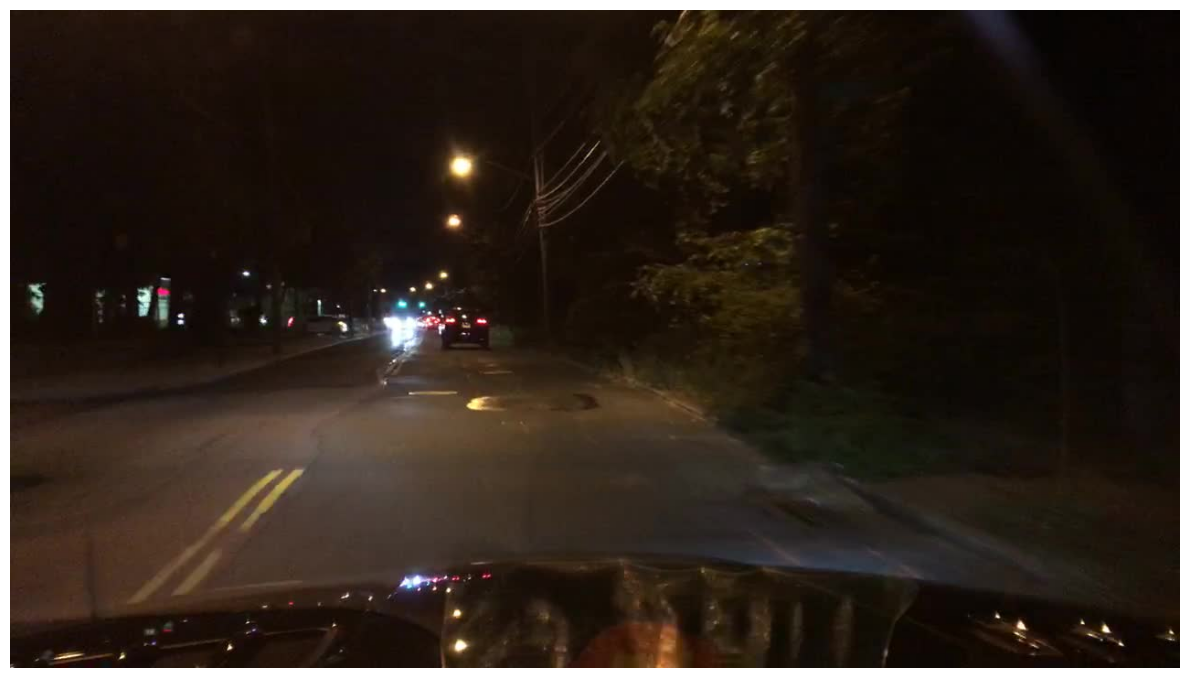

Checkpoint saved to manual_eval_bdd_checkpoint.json

Evaluation paused. Run the notebook again to continue.


In [29]:
# Set parameters
dataset_name = "bdd"  # Options: "waymo", "nuimages", "bdd"
sample_size = 10  # Number of samples per table
checkpoint_path = None  # Optional: Specify a custom checkpoint path

# Run evaluation
evaluate_questions(dataset_name, sample_size, checkpoint_path)
# waymo results yes to no
# glboal yes to no 84-106
# are there more was 49-51
# quadrants was 0-10
# thirds 
# leftmost 3-7
# rightmost 6-4
# how many 5-5
# width appears larger 2-8
# left of 6-4
# right of 9-1
# appears most 2-8
# most clustered 1-1

## View Results

After completing the evaluation or if you want to check your progress, run the cell below to view the current results.

In [ ]:
def view_results(dataset_name):
    """View evaluation results"""
    results_path = f"manual_eval_{dataset_name}_results.json"
    checkpoint_path = f"manual_eval_{dataset_name}_checkpoint.json"
    
    # Try results file first
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            results = json.load(f)
        
        print(f"Results for {dataset_name} dataset:")
        print(f"Yes count: {results['yes_count']}")
        print(f"No count: {results['no_count']}")
        print(f"Applicability rate: {results['applicability_rate']*100:.2f}%")
        
    # If no results file, check checkpoint
    elif os.path.exists(checkpoint_path):
        with open(checkpoint_path, 'r') as f:
            checkpoint = json.load(f)
        
        print(f"Checkpoint for {dataset_name} dataset:")
        print(f"Current table: {checkpoint.get('current_table', '')}")
        print(f"Current index: {checkpoint.get('current_idx', 0)}")
        print(f"Yes count: {checkpoint.get('yes_count', 0)}")
        print(f"No count: {checkpoint.get('no_count', 0)}")
        
        if checkpoint.get('yes_count', 0) + checkpoint.get('no_count', 0) > 0:
            applicability_rate = checkpoint.get('yes_count', 0) / (checkpoint.get('yes_count', 0) + checkpoint.get('no_count', 0))
            print(f"Current applicability rate: {applicability_rate*100:.2f}%")
    
    else:
        print(f"No results or checkpoint found for {dataset_name} dataset.")

# Replace with your dataset name
view_results("waymo")